In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [5]:
data_loader.supercategories

['person',
 'animal',
 'vehicle',
 'outdoor',
 'accessory',
 'sports',
 'kitchen',
 'food',
 'furniture',
 'electronic',
 'appliance',
 'indoor']

In [6]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

OOD
1    93700
0    28518
Name: count, dtype: int64

In [7]:
# ood_category = ['vehicle']
# ind_category = [x for x in data_loader.supercategories if x not in ood_category]
# df_table['OOD'] = df_table['supercategory'].apply(lambda x: 1 if any(item in x for item in ind_category) else 0)
# df_table['OOD'].value_counts()

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [8]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

    

In [9]:
#dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
#dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
#dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [10]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [11]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

#if data_loader.data_source == "qa":
#    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

In [12]:
#df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
#df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

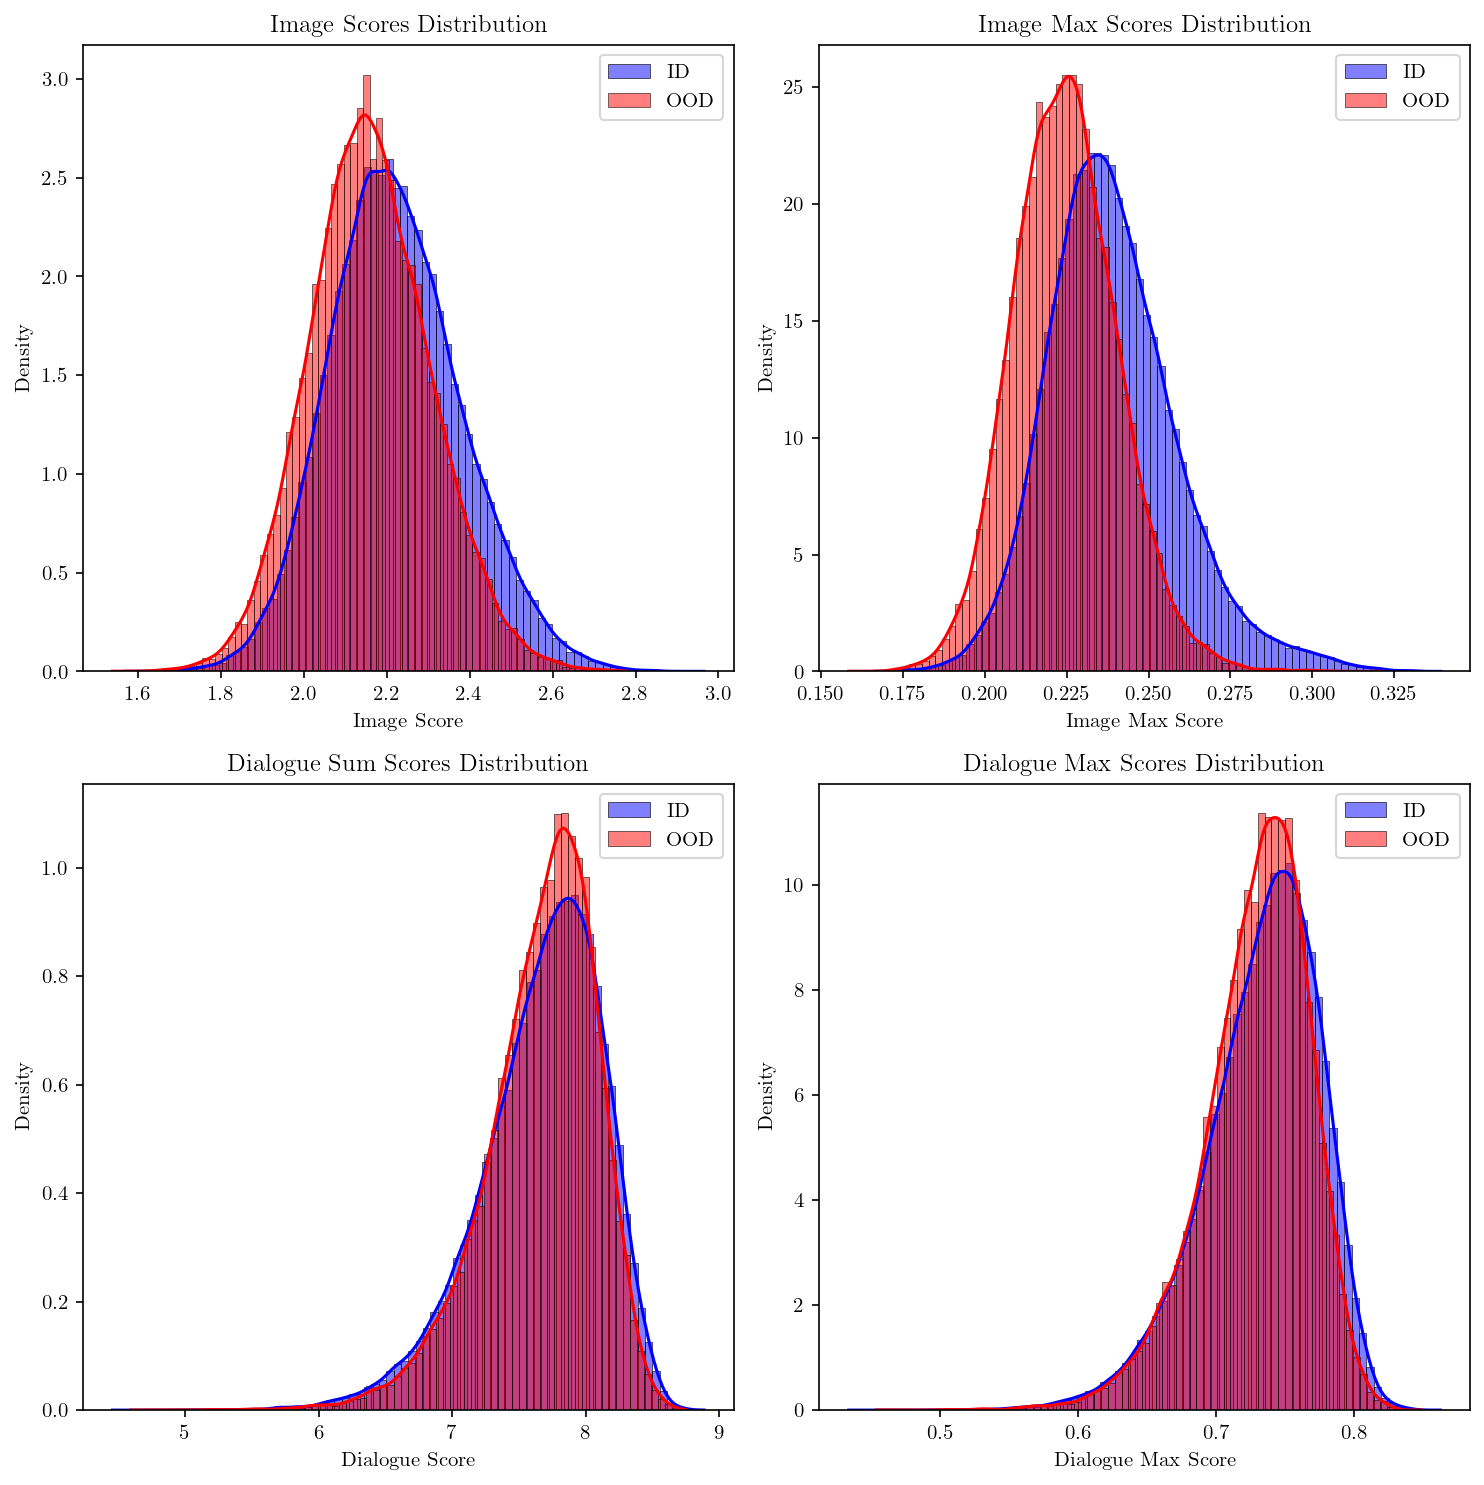

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams['figure.dpi'] = 150 
# Assuming df_table is preloaded with the appropriate columns
# Simplifying the code and plotting all histograms in a 2x2 layout

# Create figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Data for histograms
columns = ['image_score', 'image_score_max', 'dialogue_score', 'dialogue_score_max'] #'dialogue_score_segment', 'dialogue_score_segment_max']
titles = ['Image Scores Distribution', 'Image Max Scores Distribution',
          'Dialogue Sum Scores Distribution', 'Dialogue Max Scores Distribution']
         #'Dialogue Segment Sum Scores Distribution', 'Dialogue Segment Max Scores Distribution']
x_labels = ['Image Score', 'Image Max Score', 'Dialogue Score', 'Dialogue Max Score'] # 'Dialogue Segment Score', 'Dialogue Segment Max Score']

# Loop through to plot each histogram in its subplot
for i, ax in enumerate(axs.flatten()):
    ood_scores = df_table[df_table['OOD'] == 0][columns[i]]
    non_ood_scores = df_table[df_table['OOD'] == 1][columns[i]]
    sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue', ax=ax, stat="density")
    sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', ax=ax, stat="density")
    ax.legend(loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [14]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [15]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + 0.01*df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = df_table['image_text_similarity'] * (df_table['image_score'] + 0.01*df_table['dialogue_score'])

In [16]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))

Image Max: 0.8314748579844309
Image Sum: 0.9029034294130023
Dialogue Max: 0.9546602146013045
Dialogue Sum: 0.9604109685111157
Overall Max: 0.9319377235430255
Overall Sum: 0.9437548215162354


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=6,
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)


2024-05-17 21:33:07,501 - notebook_logger - INFO - Setting random seed: 20


In [18]:
dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=6,
                                    learning_rate=0.001,
                                    seed = 20)

2024-05-17 21:33:07,512 - notebook_logger - INFO - Setting random seed: 20


In [19]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 5000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

In [20]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test)

100%|██████████| 6/6 [01:16<00:00, 12.80s/it]


In [21]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test)

100%|██████████| 6/6 [01:17<00:00, 12.87s/it]


In [22]:
score_type_list = ["mp", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

2024-05-17 21:35:44,658 - notebook_logger - INFO - Test Loss: 0.1831, Test Accuracy: 0.4736
2024-05-17 21:35:46,131 - notebook_logger - INFO - Test Loss: 0.3203, Test Accuracy: 0.3274
2024-05-17 21:35:47,566 - notebook_logger - INFO - Test Loss: 0.1831, Test Accuracy: 0.4736
2024-05-17 21:35:49,083 - notebook_logger - INFO - Test Loss: 0.3203, Test Accuracy: 0.3274
2024-05-17 21:35:50,510 - notebook_logger - INFO - Test Loss: 0.1831, Test Accuracy: 0.4736
2024-05-17 21:35:51,941 - notebook_logger - INFO - Test Loss: 0.3203, Test Accuracy: 0.3274
2024-05-17 21:35:53,443 - notebook_logger - INFO - Test Loss: 0.1831, Test Accuracy: 0.4736
2024-05-17 21:35:54,855 - notebook_logger - INFO - Test Loss: 0.3203, Test Accuracy: 0.3274


In [23]:
score_type = "energy"
type = "sum"
mode = "image"
fpr = 95

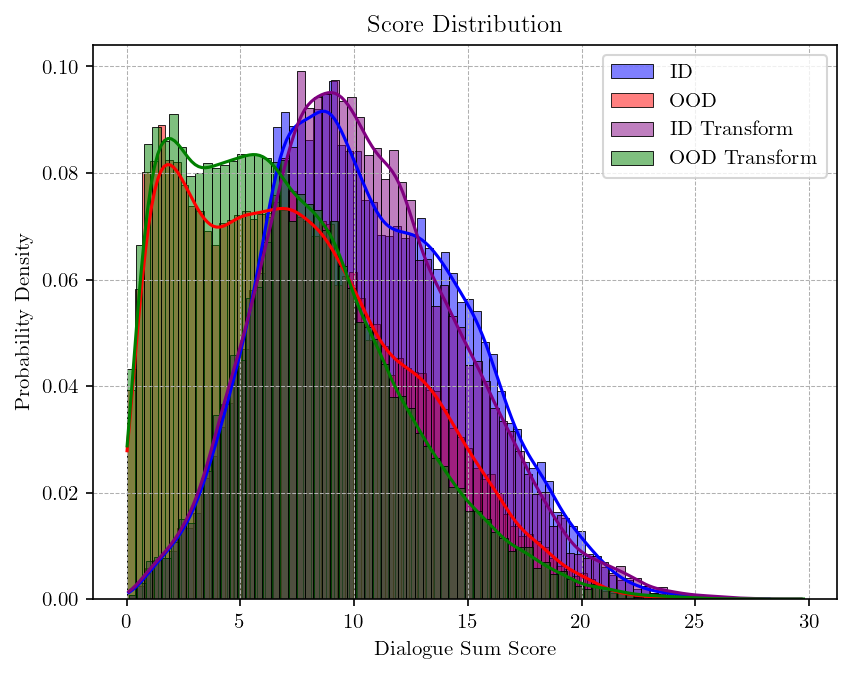

In [24]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{mode}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{mode}']

ood_scores_transform = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_{mode}_tranform']
non_ood_scores_transform = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_{mode}_tranform']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")

sns.histplot(non_ood_scores_transform, bins=80, alpha=0.5, label='ID Transform', kde=True, color='purple',stat="density")
sns.histplot(ood_scores_transform, bins=80, alpha=0.5, label='OOD Transform', kde=True, color='green', stat="density")

plt.title(f'Score Distribution')
plt.xlabel(f'Dialogue {type.title()} Score')
plt.ylabel('Probability Density')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:47: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:47: SyntaxWarning: invalid escape sequence '\%'
<>:67: SyntaxWarning: invalid escape sequence '\%'
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_25584\1473266449.py:25: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_25584\1473266449.py:47: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
C:\Users\WFYIT\AppData\Local\Temp\ipykernel_25584\1473266449.py:67: SyntaxWarning: invalid escape sequence '\%'
  plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}'

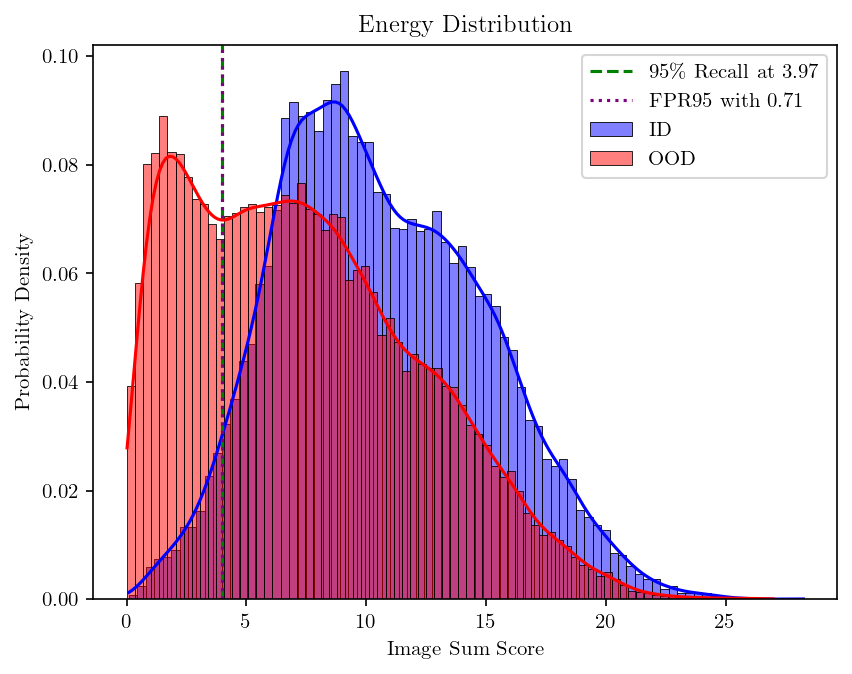

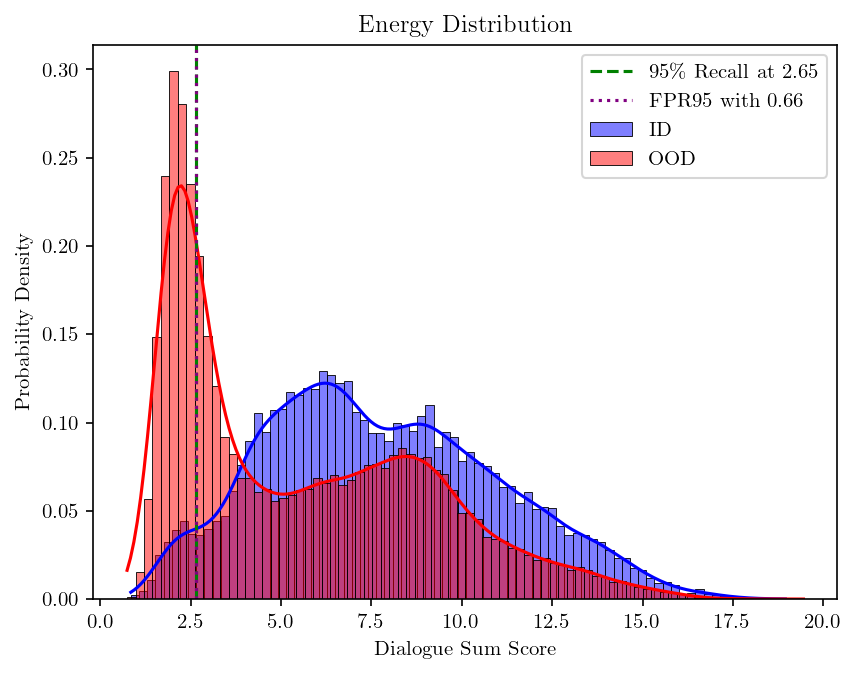

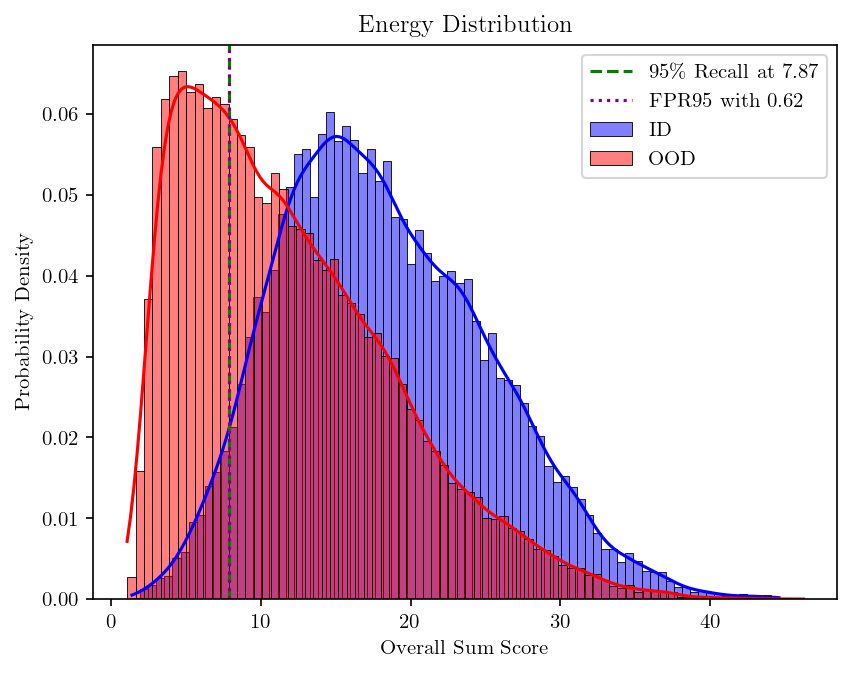

In [26]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image']

ood_scores_transform = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_image_tranform']
non_ood_scores_transform = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_image_tranform']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
#sns.histplot(non_ood_scores_transform, bins=80, alpha=0.5, label='ID', kde=True, color='green',stat="density")
#sns.histplot(ood_scores_transform, bins=80, alpha=0.5, label='OOD', kde=True, color='purple', stat="density")

plt.title(f'{score_type.title()} Distribution')
plt.xlabel(f'Image {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
#plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_{type}_image.pdf')
plt.show()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_{type}_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_{type}_dialogue']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Dialogue {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
plt.show()

ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity_{type}']
non_ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity_{type}']
sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',  stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red',  stat="density")
plt.title('Energy Distribution')
plt.xlabel(f'Overall {type.title()} Score')
plt.ylabel('Probability Density')
hist_id, bins_id = np.histogram(non_ood_scores, bins=80, density=True)
cumulative_id = np.cumsum(hist_id * np.diff(bins_id))
threshold_index_id = np.where(cumulative_id >= (1 - fpr/100))[0][0]
threshold_value_id = bins_id[threshold_index_id]
hist_ood, bins_ood = np.histogram(ood_scores, bins=80, density=True)
cumulative_ood = np.cumsum(hist_ood * np.diff(bins_ood))
threshold_index_ood = np.searchsorted(bins_ood, threshold_value_id) - 1
cumulative_probability_ood = cumulative_ood[threshold_index_ood]
plt.axvline(x=threshold_value_id, color='green', linestyle='--', label=f'{fpr}\% Recall at {threshold_value_id:.2f}')
plt.axvline(x=threshold_value_id, color='purple', linestyle=':', label=f'FPR{fpr} with {(1 - cumulative_probability_ood):.2f}')
plt.legend()
#plt.savefig(f'{data_loader.data_dir}/CLIP/qa_imgs/{score_type}_overall_simialrity_{type}.pdf')
plt.show()

In [34]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.9),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max')
    },
    "Max Prob": {
        "Image": eval_dict('mp_max_image'),
        "Dialogue": eval_dict('mp_max_dialogue'),
        "Overall": eval_dict('mp_overall_simialrity_max')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result[['Image', 'Dialogue', 'Overall']].loc[['Max Cosine', 'Sum Cosine', 'MSP', 'Max Prob', 'Max Logits', 'Sum Logits','Energy Sum', 'Energy Max']]

Metric,Image,Dialogue,Overall
Score,,,
Max Cosine,"[0.723, 0.685, 0.545]","[0.905, 0.531, 0.401]","[0.875, 0.597, 0.469]"
Sum Cosine,"[0.833, 0.594, 0.449]","[0.917, 0.507, 0.382]","[0.895, 0.551, 0.415]"
MSP,"[0.814, 0.595, 0.471]","[0.677, 0.645, 0.48]","[0.647, 0.694, 0.509]"
Max Prob,"[0.628, 0.68, 0.496]","[0.58, 0.681, 0.501]","[0.556, 0.732, 0.536]"
Max Logits,"[0.628, 0.68, 0.496]","[0.58, 0.681, 0.501]","[0.559, 0.738, 0.573]"
Sum Logits,"[0.971, 0.452, 0.365]","[0.963, 0.433, 0.35]","[0.984, 0.416, 0.341]"
Energy Sum,"[0.612, 0.692, 0.507]","[0.548, 0.69, 0.5]","[0.544, 0.745, 0.567]"
Energy Max,"[0.628, 0.68, 0.496]","[0.58, 0.681, 0.501]","[0.565, 0.736, 0.573]"


In [33]:
markdown_table = result[['Image', 'Dialogue', 'Overall']].to_markdown()
markdown_table

'| Score      | Image                 | Dialogue              | Overall               |\n|:-----------|:----------------------|:----------------------|:----------------------|\n| Energy Max | [0.628, 0.68, 0.496]  | [0.58, 0.681, 0.501]  | [0.565, 0.736, 0.573] |\n| Energy Sum | [0.612, 0.692, 0.507] | [0.548, 0.69, 0.5]    | [0.544, 0.745, 0.567] |\n| MSP        | [0.814, 0.595, 0.471] | [0.677, 0.645, 0.48]  | [0.647, 0.694, 0.509] |\n| Max Cosine | [0.723, 0.685, 0.545] | [0.905, 0.531, 0.401] | [0.875, 0.597, 0.469] |\n| Max Logits | [0.628, 0.68, 0.496]  | [0.58, 0.681, 0.501]  | [0.559, 0.738, 0.573] |\n| Max Prob   | [0.628, 0.68, 0.496]  | [0.58, 0.681, 0.501]  | [0.556, 0.732, 0.536] |\n| Sum Cosine | [0.833, 0.594, 0.449] | [0.917, 0.507, 0.382] | [0.895, 0.551, 0.415] |\n| Sum Logits | [0.971, 0.452, 0.365] | [0.963, 0.433, 0.35]  | [0.984, 0.416, 0.341] |'

## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






